In [25]:
#install.packages("MatrixModels")
#install.packages("vegan")
#install.packages("phyloseq")
install.packages("ggpubr", dependencies = TRUE)
#install.packages("corrplot")
#install.packages("ecodist")
#install.packages("Hmisc")
#install.packages("rstatix", dependencies = TRUE)
#install.packages("car", dependencies = TRUE)
#install.packages("quantreg", dependencies = TRUE)
#install.packages("MatrixModels", dependencies = TRUE)


Installing package into ‘/home/strawberry/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

also installing the dependencies ‘MatrixModels’, ‘quantreg’, ‘car’, ‘rstatix’


Warning message in install.packages("ggpubr", dependencies = TRUE):
“installation of package ‘MatrixModels’ had non-zero exit status”
Warning message in install.packages("ggpubr", dependencies = TRUE):
“installation of package ‘quantreg’ had non-zero exit status”
Warning message in install.packages("ggpubr", dependencies = TRUE):
“installation of package ‘car’ had non-zero exit status”
Warning message in install.packages("ggpubr", dependencies = TRUE):
“installation of package ‘rstatix’ had non-zero exit status”
Warning message in install.packages("ggpubr", dependencies = TRUE):
“installation of package ‘ggpubr’ had non-zero exit status”


In [1]:
# Diversity analysis
## Loading packages - those you can't install normally in Rstudio, quit it, open R in terminal and download package there selecting an USA mirror 
library(tidyverse)
library(data.table)
library(reshape2)
library(reshape) 
library(ggplot2)
library(RColorBrewer)
library(vegan) 
library(phyloseq) # unavailable for my R version
library(dplyr) 
#library(ggpubr) # unavailable for my R version
library(Hmisc) # unavailable for my R version
library(corrplot)
library(scales)
library(broom)
library(ecodist) # unavailable for my R version

### those with problems for downloading, I tried doing so directly from BiocManager and it worked better
#if (!require("BiocManager", quietly = TRUE))
 #   install.packages("BiocManager")

#BiocManager::install("phyloseq") # trying to download from Bioconductor 
#install.packages("ecodist")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


The following object is masked

In [2]:
## Set seed
set.seed(123)
setwd("/home/strawberry/Documents/Collaborations/mangrove/github/data")
getwd()

[1] "/home/strawberry/Documents/Collaborations/mangrove/github/data"

In [3]:
## Loading frequency table with taxonomic annotation 
ReadCounts_TaxAnnotation <- read.delim("./ReadCounts_TaxAnnotation.txt", h=T) 

Using Counts as value column: use value.var to override.



[1] 599

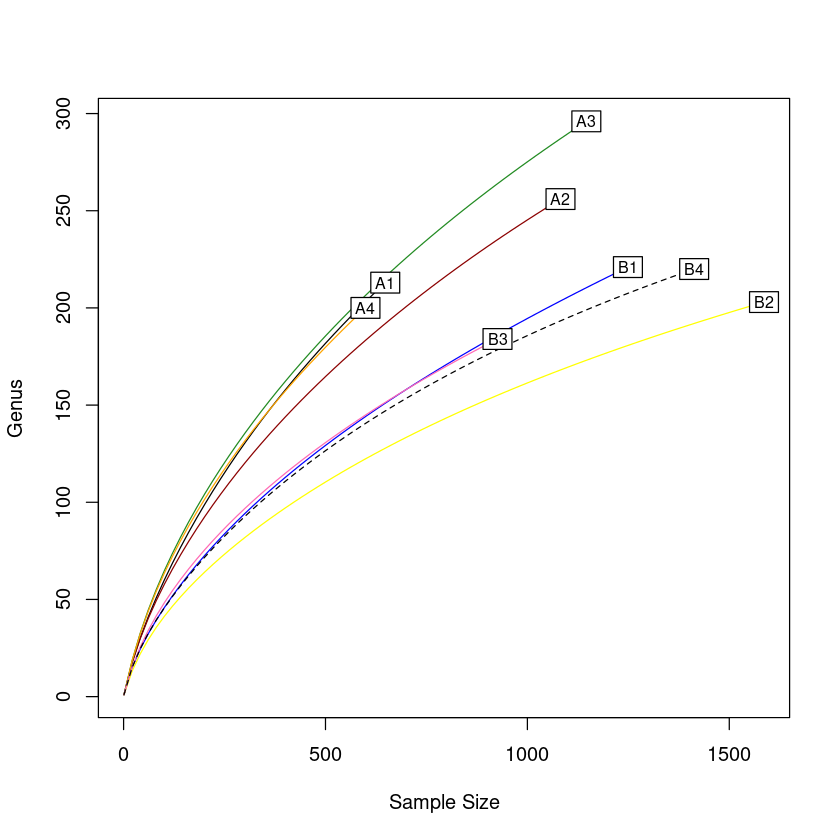

In [4]:
## Rarefaction analysis 
df <- aggregate(ReadCounts_TaxAnnotation$Counts, list(ReadCounts_TaxAnnotation$Genus, ReadCounts_TaxAnnotation$ID_Sample), FUN=sum) 
colnames(df) <- c("Genus", "ID_Sample", "Counts") 
cast_data = acast(df, ID_Sample ~ Genus) 
cast_data[is.na(cast_data)] <- 0 
raremax <- min(rowSums(cast_data)) 
raremax # output 599

col <- c("black", "darkred", "forestgreen", "orange", "blue", "yellow", "hotpink") 
lty <- c("solid", "dashed", "longdash", "dotdash") 
pars <- expand.grid(col = col, lty = lty, stringsAsFactors = FALSE) 
out <- with(pars[1:20, ], rarecurve(cast_data, step = 20, col = col, lty = lty, label = TRUE, ylab = "Genus")) 


ERROR: Error in stat_compare_means(method = "wilcox.test", comparisons = a_my_comparisons, : could not find function "stat_compare_means"


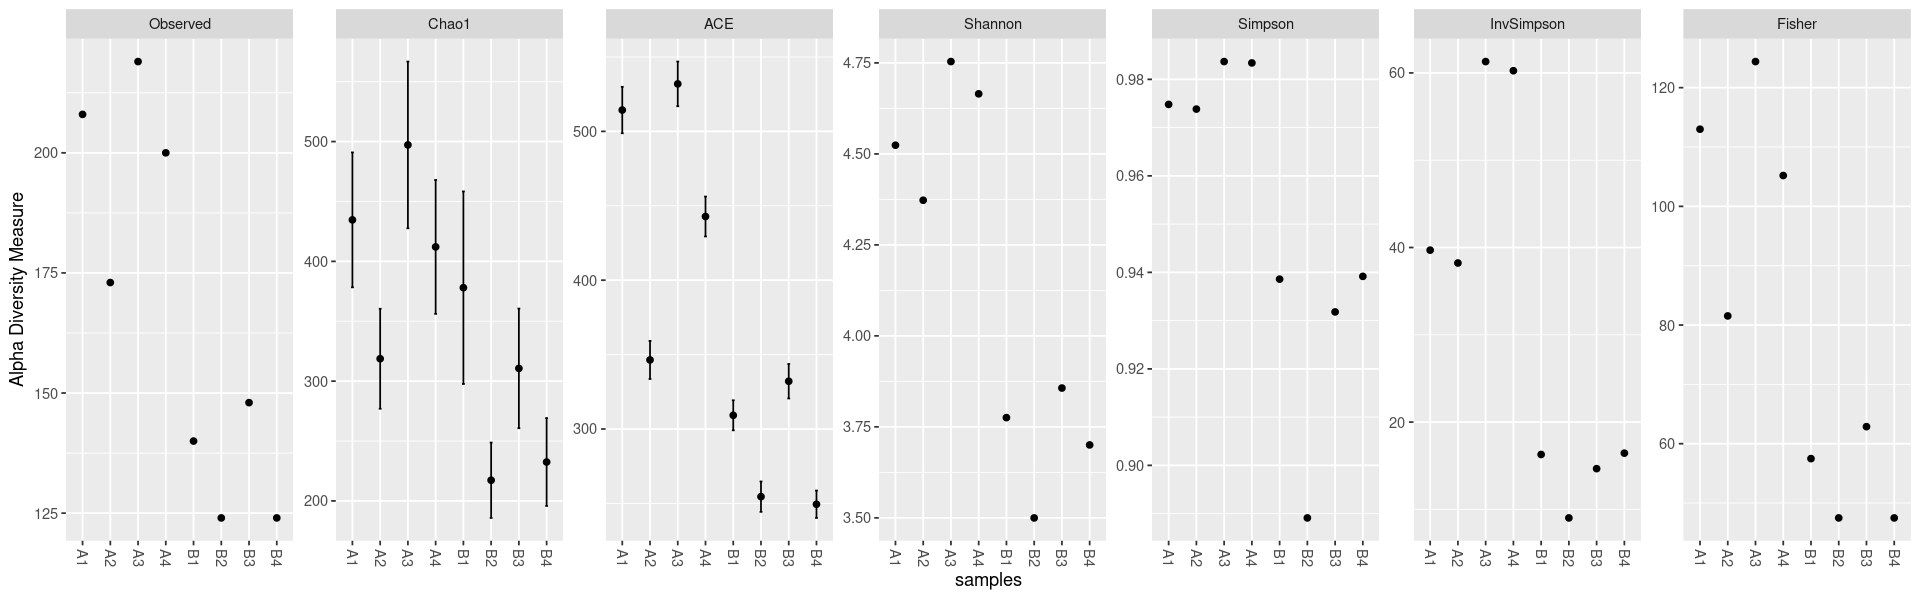

In [5]:
## Alpha diversity
metadata <- read.delim("./metadata_nreads.tsv", h=T)
rarefied_data <- rrarefy(cast_data, raremax)
OTU = otu_table(rarefied_data, taxa_are_rows = FALSE) 
sampledata = sample_data(metadata) 
rownames(sampledata) <- sampledata$ID_Sample 
sampledata <- sampledata[,-1] 
physeq1 = phyloseq(OTU,sampledata) 
richness <- estimate_richness(physeq1)
write.table(richness, "AlhaDiversity_Indexes", quote = F, sep = "\t", row.names = T)
options(repr.plot.width=16, repr.plot.height=5) 
plot_richness(physeq1, )

options(repr.plot.width=6, repr.plot.height=5) 
a_my_comparisons <- list(c("Araçá", "Colhereiro")) # indicating the groups I want to compare, so I can join the alpha diversity values obtained by each replica 
symnum.args = list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05, 1), symbols = c("****", "***", "**", "*", "ns")) # indicating levels of significance 
A <- plot_richness(physeq1, x="Mangrove", measures="Observed", color = "Mangrove")+ geom_boxplot(alpha=0.6)+ theme(legend.position="none", axis.text.x=element_text(angle=45,hjust=1,vjust=1,size=12))+ stat_compare_means(method = "wilcox.test", comparisons = a_my_comparisons, label = "p.signif", symnum.args = symnum.args) 
B <- plot_richness(physeq1, x="Mangrove", measures="Chao1", color = "Mangrove")+ geom_boxplot(alpha=0.6)+ theme(legend.position="none", axis.text.x=element_text(angle=45,hjust=1,vjust=1,size=12))+ stat_compare_means(method = "wilcox.test", comparisons = a_my_comparisons, label = "p.signif", symnum.args = symnum.args) 
C <- plot_richness(physeq1, x="Mangrove", measures="Shannon", color = "Mangrove")+ geom_boxplot(alpha=0.6)+ theme(legend.position="none", axis.text.x=element_text(angle=45,hjust=1,vjust=1,size=12))+ stat_compare_means(method = "wilcox.test", comparisons = a_my_comparisons, label = "p.signif", symnum.args = symnum.args) 
D <- plot_richness(physeq1, x="Mangrove", measures="Simpson", color = "Mangrove")+ geom_boxplot(alpha=0.6)+ theme(legend.position="none", axis.text.x=element_text(angle=45,hjust=1,vjust=1,size=12))+ stat_compare_means(method = "wilcox.test", comparisons = a_my_comparisons, label = "p.signif", symnum.args = symnum.args) 

options(repr.plot.width=12, repr.plot.height=12)

ggarrange(A, B, C, D, 
          labels = c("A", "B", "C", "D"),
          font.label = list(size = 18),
          ncol = 4, nrow = 1) # this will couple the plots, arranging them (in this case) in 4 columns and 1 row (Zaramela chose to arrange them in 2 columns and 2 rows)


ERROR: Error in eval(expr, envir, enclos): object 'A' not found


In [12]:
## Beta diversity
### Creating the relative abundance table
tcast_data <- t(cast_data) # transposes the count data matrix to have samples as rows and taxa as columns
relative_abundance <- (t(tcast_data) / apply(tcast_data, 2, sum))*100 # Calculates the relative abundance by dividing each count by the sum of counts in each sample and multiplying by 100 to get percentages; apply function Calculates the sum of counts for each sample
relative_abundance <- t(relative_abundance) # Transposes the relative abundance matrix back to the original format.
write.table(relative_abundance, file = "relative_abundance.tsv", sep = "\t", row.names = TRUE)

### Calculates Bray-Curtis distances between samples
bray_curtis_dist <- vegan::vegdist(t(relative_abundance), method = "bray") # Calculates the Bray-Curtis dissimilarity matrix using the transposed relative abundance matrix as input 
bray_curtis_pcoa <- ecodist::pco(bray_curtis_dist) # Performs Principal Coordinate Analysis (PCoA) on the Bray-Curtis dissimilarity matrix to obtain principal coordinate axes

bray_curtis_pcoa_df <- data.frame(pcoa1 = bray_curtis_pcoa$vectors[,1], 
                                  pcoa2 = bray_curtis_pcoa$vectors[,2],
                                  pcoa3 = bray_curtis_pcoa$vectors[,3]) # Creates a df to store the PCoA results and assigns the first three principal coordinate axes to columns in the data frame

bray_curtis_pcoa_df$ID_Sample <- colnames(relative_abundance) # Assigns sample IDs as a new column in the data frame
dist_metadata <- merge(metadata, bray_curtis_pcoa_df, by = "ID_Sample") # Merges the metadata with the PCoA results based on sample IDs.
write.table(bray_curtis_pcoa_df, file = "PCoA_values_samples.tsv", sep = "\t", row.names = FALSE)

### Setting up the parameters for plotting and its colors and groups 
options(repr.plot.width=5, repr.plot.height=4)
clustid <- dist_metadata$Mangrove 
my_palette <- c("#ff91a4", "#006994")
group <- c("Araçá", "Colhereiro")
dist_metadata$Mangrove <- factor(dist_metadata$Mangrove, levels = group, ordered = TRUE) # Converts the mangrove group variable to a factor with specified levels and ordering


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


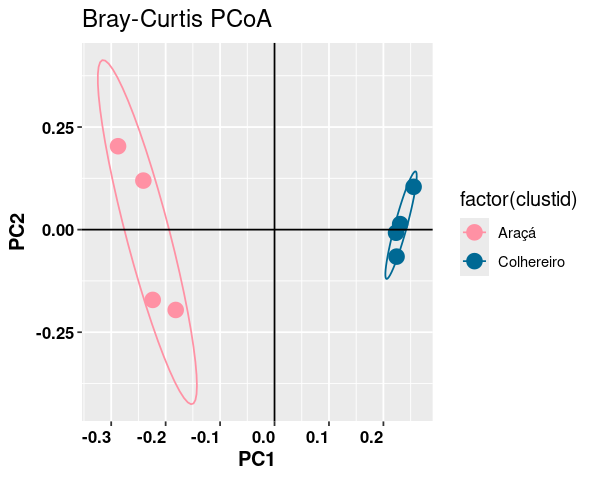

In [13]:
### Create a plot
bray_curtis_plot <- ggplot(data = dist_metadata, aes(x=pcoa1, y=pcoa2, color=factor(clustid))) +
  geom_point(size = 4) +   
  stat_ellipse(level = 0.8) +
        scale_color_manual(values = my_palette) +
        geom_hline(yintercept=0) +
        geom_vline(xintercept=0) +
  scale_color_manual(values = my_palette) +
  labs(x = "PC1",
       y = "PC2", 
       title = "Bray-Curtis PCoA") +
  theme(title = element_text(size = 12), # makes titles smaller
        axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text.y = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text = element_text(size = 12, colour = "black", face="bold"),
        axis.title = element_text(size = 12, colour = "black", face="bold"))
bray_curtis_plot